In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
PyOpenGL==3.1.* \
PyOpenGL-accelerate==3.1.* \
gym[box2d]==0.17.* 
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 1s (875 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.

In [2]:
!rm ./vid/*.*

rm: cannot remove './vid/*.*': No such file or directory


In [7]:
from gym import Env, spaces
import numpy as np
import random

In [8]:
class SteeringWheelEnv(Env):
  """
  Environment to replicate automated steering of the wheel in an environment (road)
  """
  def __init__(self):

    # The first set of action is the degree of turn
      # -1 indicates complete left turn, 1 indicates complete right turn and 0 indicates wheel is aligned centered
    # The second set of action is change in speed of the vehicle.
      # Here we will consider 0 as speed reduction and 1 as speed increase 
    #self.action_space = spaces.MultiDiscrete([3,2])        
    self.action_space = spaces.Tuple((
                                        spaces.Box(low=np.array([-1]), high=np.array([1])),
                                        spaces.Discrete(2)
                                      ))


    # degree of turn of the road from left(negative) to right(positve)
    # self.observation_space = spaces.Box(low=np.array([-1]), high=np.array([1]))    
    
    # The environment returns 
      # (Continuous)the amount of turn required for the road ahead. Here -1 indicates left turn, 0 indicates straight road and 1 indicating right turn.
      # (Continuous)the position of the vehicle with respect to the current road lane. -1 indicating extreme left, 0 for center and 1 for extreme right
    self.observation_space = spaces.Tuple((
                                            spaces.Box(low=np.array([-1]), high=np.array([1])),
                                            spaces.Box(low=np.array([-1]), high=np.array([1]))
                                          ))

    # intial randomized turn of the road
    self.road_turn = random.uniform(-1,1)
    # intial position of vehicle on the orad
    self.road_position = random.uniform(-1,1)
    # amount of turn ± from 0 that will be considered almost straight road. Used by the state road_turn
    self.turn_margin_to_center = 0.2

    # duration of drive
    self.drive_duration = 100   # seconds

    # margin of error accepted for the vehicle to be considered aligned with the road (center). Used by the state road_position
    self.vehicle_road_center_threshold = 0.4


  def step(self, action):
    # decrease time step
    self.drive_duration -= 1

    action_turn, action_speed = action        # float, integer

    # get updated road postion of vehicle after action execution
    self.road_position = self.get_updated_road_position(self.road_position, self.road_turn, action_turn, action_speed)
    # assigning default reward to action
    reward = -1

    if self.road_turn < -self.turn_margin_to_center or self.road_turn > self.turn_margin_to_center:     # road is turning left or right
      # when turning need to reduce speed
      if action_speed == 0:
        if self.road_position>=-self.vehicle_road_center_threshold and self.road_position<=self.vehicle_road_center_threshold:
          # wheel and road turn are aligned straight. The vehicle is almost center of the road
          reward = 1
    else:
      # for straight road
      if action_turn >= -self.turn_margin_to_center and action_turn <= self.turn_margin_to_center:
          # wheel and road turn are aligned straight. The vehicle is almost center of the road
          if self.road_position>= -self.vehicle_road_center_threshold and self.road_position<= self.vehicle_road_center_threshold:
            reward = 1
    
    # get next state after action
    self.road_turn, self.road_position = self.get_next_state(self.road_turn, self.road_position)
    # check if task is done     
    if self.drive_duration >0:
      task_done = False
    else:
      task_done = True

    return (self.road_turn, self.road_position), reward, task_done, {}

  
  def get_updated_road_position(self, road_position, road_turn, action_turn, action_speed):
    """
    Return the updated vehicle road position based on turning and speed change action of the agent
    """
    
    # NOTE: Probability is used in effect of road turn in position in order to simulate real-world scenarios(noise) 
    # like misjudged wheel turn, obstacles on road, etc
    

    update_margin = 0.0
    # For left turning road
    if road_turn < -self.turn_margin_to_center:    # this means the road_turn is pushing towards -1 (left)
      # For low speed
      if action_speed == 0:
        if action_turn < -self.turn_margin_to_center: 
          # vehicle also turning left
          update_margin = action_turn -road_turn           
        elif action_turn > self.turn_margin_to_center:       
          # for vehicle turning right in a left turning road
          update_margin = (-1*road_turn) + action_turn
        else:                     
          # for vehicle going straight in a left turning road
          update_margin = (-1*road_turn)                # road_turn is negative(towards left) and hence the vehicle position is displaced towards the right (positve)
      if action_speed == 1:
        # For higher speed, the effect of turn is less
        update_margin /= 2 

    # For right turning road
    elif road_turn > self.turn_margin_to_center:       # this means the road_turn is pushing towards 1 (right)
      # For low speed
      if action_speed == 0:
        if action_turn > self.turn_margin_to_center:       
        # vehicle also turning right
          update_margin = action_turn - road_turn           
        elif action_turn < -self.turn_margin_to_center:    
        # for vehicle turning left in a right turning road
          update_margin = (-1*road_turn) + action_turn
        else:                    
        # for vehicle going straight in a right turning road
          update_margin = (-1*road_turn)                # road_turn is positive(towards right) and hence the vehicle position is displaced towards the left (negative)
      if action_speed == 1:
        # For higher speed, the effect of turn is less
        update_margin /= 2 
    
    # For straight road
    else:
      if action_turn < -self.turn_margin_to_center: 
        # vehicle turning left
        update_margin = action_turn - road_turn             # vehicle moves towards left side of the lane (negative)
      elif action_turn > self.turn_margin_to_center:
        # vehicle turning right
        update_margin = action_turn - road_turn             # vehicle moves towards right side of the lane (positive)
      else:
        update_margin = 0.0

    if update_margin:
      road_position += update_margin
    return road_position


  def get_lower_and_upper_limit(self, val):
    """
    Get next road turn range
    """
    lower_limit = -1
    upper_limit = 1
    if val - self.turn_margin_to_center>-1:
      lower_limit = val - self.turn_margin_to_center
    if val + self.turn_margin_to_center<1:
      upper_limit = val + self.turn_margin_to_center
    return lower_limit, upper_limit


  def get_next_state(self, road_turn, road_position):
    """
    Get next state of environment given the current state.
    """
    lower_limit, upper_limit = self.get_lower_and_upper_limit(road_turn)
    next_road_turn = random.uniform(lower_limit, upper_limit)

    if next_road_turn < -self.turn_margin_to_center:
      # For left
      road_position += next_road_turn
    elif next_road_turn > self.turn_margin_to_center:
      road_position += next_road_turn
    else:
      road_position = road_position   # no change for straight road

    if road_position<-1:
      road_position = -1
    if road_position >1:
      road_position = 1
    return next_road_turn, road_position


  def reset(self):
    """
    Reset environment states
    """
    # intial randomized turn of the road
    self.road_turn = random.uniform(-1,1)
    # intial position of vehicle on the orad
    self.road_position = random.uniform(-1,1)
    
    # reset duration of drive
    self.drive_duration = 100   # seconds
    return self.road_turn, self.road_position


In [9]:
env = SteeringWheelEnv()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
 from google.colab import drive
 import sys
 drive.mount('/content/drive')
 sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/RL')
 import mdp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
'''
Converting the continuous state to discrete state. The state of environment observed are:
  - s_l : state left    discrete state where vehicle is on left side of the lane
  - s_c : state center  discrete state where vehicle is around the center of the lane and gets reward
  - s_r : state right   discrete state where vehicle is on right side of the lane

The action spaces consists two types of action: (i) turn of steering wheel and (ii) vehicle speed alteration
  - turn of steering wheel is discretized into three actions left(-1), right(1) and center (0)
  - vehicle speed is discrete action with values 0 for speed reduction and  1 for speed increase of the vehicle which affects angular velocity of the vehicle

Let us consider that the combination of 2 actions are given as:
  - a_lr : left wheel steer and reduce speed
  - a_li : left wheel steer and increase speed
  - a_rr : right wheel steer and reduce speed
  - a_ri : right wheel steer and increase speed
  - a_cr : no wheel steer and reduce speed
  - a_ci : no wheel steer and increase speed
'''
transition_probs = {
    # State: center of the lane
    's_c': {
        'a_lr': {'s_c': 0.1, 's_l': 0.9},
        'a_li': {'s_c': 0.2, 's_l': 0.7, 's_r': 0.1},         # the s_r is consequence due to real-world noise such as turn of road or obstacles on it
        'a_rr': {'s_c': 0.1, 's_r': 0.9},
        'a_ri': {'s_c': 0.2, 's_l': 0.1, 's_r': 0.7},
        'a_cr': {'s_c': 1},         
        'a_ci': {'s_c': 0.8, 's_l': 0.1, 's_r': 0.1}          # s_r and s_l state transition probabilities indicate noise
    },    
    # State: left side of the lane
    's_l': {
        'a_lr': {'s_l': 1},
        'a_li': {'s_l': 1},
        'a_rr': {'s_c': 0.7, 's_l': 0.1, 's_r': 0.2},
        'a_ri': {'s_c': 0.4, 's_l': 0.1, 's_r': 0.5},         # higher chance of going to right in faster speed. Here the noise is added for real-world scenarios like angular velocity.
        'a_cr': {'s_c': 0.2, 's_l': 0.8},
        'a_ci': {'s_c': 0.3, 's_l': 0.7}
    },
    # State: right side of the lane
    's_r': {
        'a_lr': {'s_c': 0.7, 's_l': 0.2, 's_r': 0.1},
        'a_li': {'s_c': 0.4, 's_l': 0.5, 's_r': 0.1},
        'a_rr': {'s_r': 1},
        'a_ri': {'s_r': 1},
        'a_cr': {'s_c': 0.2, 's_r': 0.8},
        'a_ci': {'s_c': 0.3, 's_r': 0.7}
    }
}
rewards = {
    's_l': {'a_rr': {'s_c': +2}, 'a_ri': {'s_c': +1},},         # going from left side of the lane to center with proper steering action
    's_r': {'a_lr': {'s_c': +2}, 'a_li': {'s_c': +1},},
    's_c': {'a_cr': {'s_c': +2}, 'a_ci': {'s_c': +4}}
}

In [18]:
from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state=random.choice(list(transition_probs.keys())))
# mdp = MDP(transition_probs, rewards, initial_state='s_l')

In [19]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a_ci')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s_r
next_state = s_c, reward = 0.0, done = False


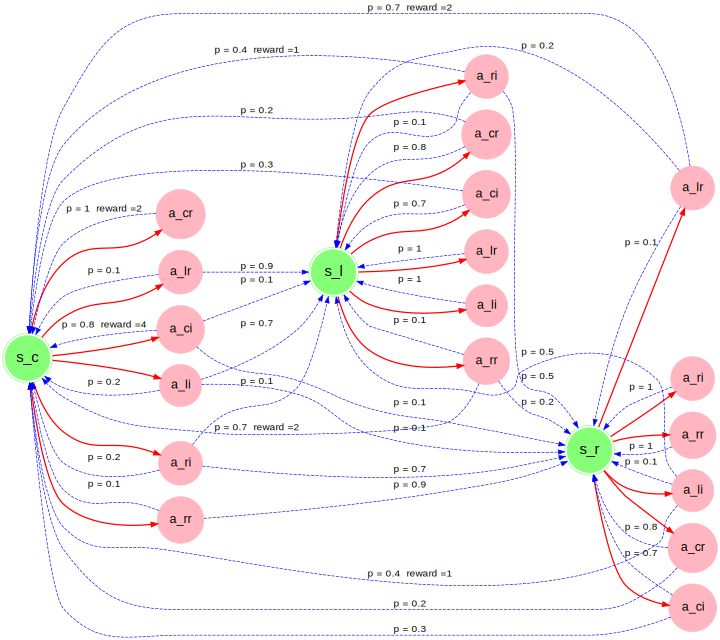

In [20]:
# Visualize the MDP model
from mdp import has_graphviz
from IPython.display import display

if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

## **Policy Iteration**

Pseudocode for Policy Iteration:

---

`1.` Initialize a random policy $\pi^0$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \sum_{a}$ $\pi$ (a|s) $\sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$    # Policy Evaluation

`4.` $ \quad \pi_{(i+1)}(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$    # Policy Improvement

`5.` Until $\pi_{(i+1)}$ converges to $\pi^*$

---

First, let's write a function to compute the state-action value function $Q({\pi})$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{i+1}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [25]:
# Compute the Q-value using the formula above
# Compute state-action value function for each state, action pair for step 3
def get_action_value(mdp, state_values, state, action_id, gamma):

    # Initialise Q
    states = mdp.get_all_states()
    Q = 0
    action = mdp.get_possible_actions(state)[action_id]
    for s in states:
      # Compute Q using the equation above
      Q = Q + mdp.get_transition_prob(state, action, s)*(mdp.get_reward(state, action, s) + \
                                                               gamma*state_values[s]) 
    return Q

In [26]:
def evaluate_policy(mdp, state_value, gamma, policy, min_difference):
  """
  Policy Evaluation/Prediction
  # Corresponding to equation in line 3 above
  Returns the states and their corresponding state-value function for each state given a policy in numpy array
  """
  states = mdp.get_all_states()
  policy_state_values = np.zeros(len(states))
  while True:
    for state_id,state in enumerate(states):
      # For each state  
      v = 0   # initialize value function

      # converting np array to dict type for mdp module
      policy_state_values_dict = {s:val for s,val in zip(states,policy_state_values)}
    
      for action_id, action_proba in enumerate(policy[state_id]):
        v += action_proba * get_action_value(mdp, policy_state_values_dict, state, action_id, gamma)

      # change in values
      delta = np.abs(policy_state_values[state_id] - v)
      # update value function
      policy_state_values[state_id] = v
      
    if delta<min_difference:
        # value converged
        # print('Value converge in iteration {}'.format(i+1))
        break
  return {s:v for s,v in zip(states,policy_state_values)}

In [87]:
def evaluate_policy_lin_system(mdp, state_value, gamma, policy):
  """
  Policy Evaluation/Prediction using linear systems
  # Corresponding to equation in line 3 above
  Returns the states and their corresponding state-value function for each state given a policy in numpy array
  """
  states = mdp.get_all_states()
  policy_state_values = np.zeros(len(states))
  
  lin_eqs = []
  lin_eqs_ops = []
  for state_id,state in enumerate(states):
    # For each state  
    current_row_eq = [0.0]*len(states)
    # assuming states in array as sc, sl, sr

    current_row_eq[state_id] = 1.0       # initialize V(π) for linear system
    actions = mdp.get_possible_actions(state)

    state_reward = 0.0

    for action_id, action_proba in enumerate(policy[state_id]):
      action = actions[action_id]
      for next_state, next_state_proba in mdp.get_next_states(state, action).items():
        # getting equ
        next_states_id = states.index(next_state)
        current_row_eq[next_states_id] -= action_proba*mdp.get_transition_prob(state, action, next_state)*gamma       # moving all variables to LHS in eq(3)
                                                                                                                      # reward on RHS in eq(3)
    
        state_reward += action_proba*mdp.get_transition_prob(state, action, next_state)*(mdp.get_reward(state, action, next_state))
    lin_eqs.append(current_row_eq)
    lin_eqs_ops.append(state_reward)
  # solving the linear systems as x = inv(A).B
  state_values_soln = np.linalg.inv(np.array(lin_eqs)).dot(np.array(lin_eqs_ops))
  return {s:v for s,v in zip(states,state_values_soln)}

In [53]:
def improve_policy(mdp, state_values, policy, gamma):
  """
  Obtain the optimal policy given the state value function
  """
  policy_stable = True
  
  for state_id, state in enumerate(mdp.get_all_states()):
      # for each state
      current_state_action = np.argmax([policy[state_id]])        # current policy
      # Init values
      state_actions = mdp.get_possible_actions(state)
      A = [a for a in state_actions ]
      v = np.zeros(len(state_actions))
      
      for action_id, action in enumerate(state_actions):
          # for each action of the state compute the Q value
          v[action_id] += get_action_value(mdp, state_values, state, action_id, gamma)

      optimal_state_action = np.argmax(v)                         # optimal policy

      if current_state_action != optimal_state_action or np.all(policy[state_id]==policy[state_id][0]):      # the second condition is when all the actions have same probability in start
        policy_stable = False
        # get the improved greedy policy
        policy[state_id] = np.eye(len(policy[state_id]))[optimal_state_action]
  return policy_stable,policy

In [28]:
def get_initial_policy(mdp):
  """
  Initialize Policy with equal proba for all actions in the start
  """
  states = mdp.get_all_states()
  num_actions = len(mdp.get_possible_actions(states[0]))
  policy = np.ones([len(states),num_actions]) / num_actions
  return policy

In [86]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 1000        # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize a random policy π
policy = get_initial_policy(mdp)
print('Intial policy: \n',policy)
# initialize V(s) for all states
state_values = {s: 0 for s in mdp.get_all_states()}
# print('Intial state value: ', state_values)

# #display the MDP model
# if has_graphviz:
#     display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    stable_policy = True
    # Evaluate current policy
    new_state_values = evaluate_policy_lin_system(mdp, state_values, gamma, policy)       # get new state values using linear solver
    # new_state_values = evaluate_policy(mdp, state_values, gamma, policy,min_difference)
    # print('Stage: {}: . new_state_values: {}'.format(i, new_state_values))

    # Policy Improvement
    policy_stable, policy = improve_policy(mdp, new_state_values, policy, gamma)
    print('Stage: {}: . Policy: {}'.format(i, policy))
    if policy_stable:
      print('Policy stable after {} iterations'.format(i+1))
      break
print('Final policy \n', policy)

Intial policy: 
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]
Stage: 0: . Policy: [[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Stage: 1: . Policy: [[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Policy stable after 2 iterations
Final policy 
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


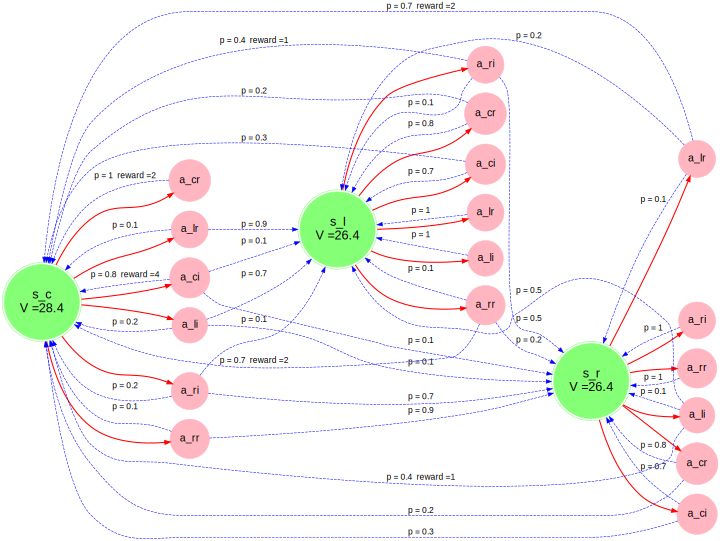

In [79]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, new_state_values))

In [80]:
def convert_cont_state_to_discrete(obs):
  """
  converting continuous state values to discrete for policy iteration implementation
  """
  road_turn, vehicle_road_pos = obs
  if (road_turn>0 and vehicle_road_pos>0) or (road_turn<0 and vehicle_road_pos<0):
    # for consuming multiple continuous states as aggregated state information
    cont_val_sum = road_turn + vehicle_road_pos
  else:
    cont_val_sum = road_turn - vehicle_road_pos
  if cont_val_sum<-0.6:
    return 's_l'
  elif cont_val_sum>0.6:
    return 's_r'
  else:
    return 's_c'

In [81]:
def get_speed_discrete_val(action):
  """
  getting binary speed action value
  """
  if action[-1] == 'i':     # indicates action to increase speed
    return 1
  else:
    return 0

In [82]:
def get_vehicle_turn_cont_val(action,obs):
  """
  Returns the turn of wheel continuous action value based on discrete action obtained from optimal policy
  """
  road_turn, vehicle_road_pos = obs
  diff = road_turn - vehicle_road_pos
  if action[-2] == 'r':       # needs right turn
    return diff
  elif action[-2] == 'l':     # needs lef turn
    return diff
  else:
    return random.uniform(-.2,.2)

In [83]:
def get_optimal_action(obs, mdp, policy):
  """
  Returns the optimal actions for the given state of env
  """
  turn = 0.0
  speed = 1   # default speed action
  discrete_state = convert_cont_state_to_discrete(obs)
  states = mdp.get_all_states()
  actions = mdp.get_possible_actions(states[0])
  discrete_state_pos = states.index(discrete_state)
  action = mdp.get_possible_actions(states[discrete_state_pos])[np.argmax(policy[discrete_state_pos])]
  speed = get_speed_discrete_val(action)
  turn = get_vehicle_turn_cont_val(action, obs)
  return turn, speed


In [89]:
# testing learned policy through policy iteartion on the environment
rewards = []
for tests in range(1000):
  o = env.reset()
  done = False
  total_reward = 0
  while not done:
    action = get_optimal_action(o, mdp, policy)
    o, reward, done, i = env.step(action)
    total_reward += reward
  # print('Total Reward Collected: {}' .format(total_reward))
  rewards.append(total_reward)

In [90]:
print('Average reward over 1000 trails', np.mean(rewards))

Average reward over 1000 trails 85.266
